In [1]:
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install pandas

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
tc.cuda.is_available()

True

In [6]:
from torchvision.datasets import MNIST

train = MNIST("", download=True, train=True)
test = MNIST("", download=True, train=False)

In [7]:
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

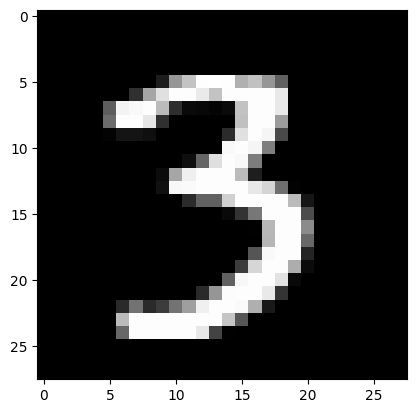

The number in the image is 3


In [8]:
image = X_train[10000]
label = y_train[10000]

plt.imshow(image, cmap="gray")
plt.show()
print("The number in the image is", label.numpy())

In [9]:
y = tc.cat((y_train, y_test)).numpy()

In [10]:
pd.Series(y).value_counts().sort_index()

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64

In [11]:
pd.Series(y).value_counts().sort_values()

5    6313
4    6824
8    6825
6    6876
0    6903
9    6958
2    6990
3    7141
7    7293
1    7877
Name: count, dtype: int64

In [12]:
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [13]:
print("Size of X_train is", X_train.shape)
print("Size of y_train is", y_train.shape)
print("Size of X_test is", X_test.shape)
print("Size of y_test is", y_test.shape)

Size of X_train is (60000, 28, 28)
Size of y_train is (60000,)
Size of X_test is (10000, 28, 28)
Size of y_test is (10000,)


In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [15]:
print("Size of X_train is", X_train.shape)
print("Size of X_test is", X_test.shape)

Size of X_train is (60000, 784)
Size of X_test is (10000, 784)


In [16]:
X_train = X_train / 255
X_test = X_test / 255

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train = tc.from_numpy(X_train).float()
y_train = tc.from_numpy(y_train)
X_test = tc.from_numpy(X_test).float()
y_test = tc.from_numpy(y_test)

In [19]:
X_train = X_train.cuda()
y_train = y_train.cuda()
X_test = X_test.cuda()
y_test = y_test.cuda()

In [20]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc1_dropout = nn.Dropout(0.3)
        init.kaiming_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2_dropout = nn.Dropout(0.2)
        init.kaiming_normal_(self.fc2.weight)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3_dropout = nn.Dropout(0.1)
        init.kaiming_normal_(self.fc3.weight)

        self.fc4 = nn.Linear(128, 10)
        init.xavier_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = tc.relu(x)
        x = self.fc1_dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = tc.relu(x)
        x = self.fc2_dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = tc.relu(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)

        return x

In [21]:
import torch.optim as optim

model = Net()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=9e-3, weight_decay=3e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [22]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 5
losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_val_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)

    model.eval()

    with tc.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            epoch_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    model.train()

    print(
        f"Epoch: {epoch + 1}/{epochs}, Training Loss: {losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}"
    )

Epoch: 1/5, Training Loss: 0.2737, Validation Loss: 0.1423
Epoch: 2/5, Training Loss: 0.1333, Validation Loss: 0.0954
Epoch: 3/5, Training Loss: 0.0935, Validation Loss: 0.0768
Epoch: 4/5, Training Loss: 0.0694, Validation Loss: 0.0717
Epoch: 5/5, Training Loss: 0.0554, Validation Loss: 0.0686


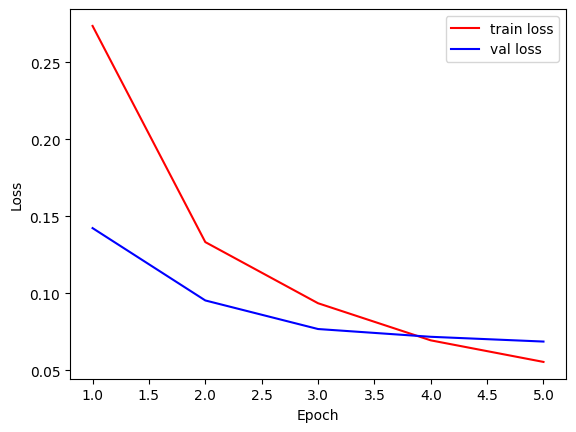

In [23]:
plt.plot(range(1, epochs + 1), losses, color="red", label="train loss")
plt.plot(range(1, epochs + 1), val_losses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
model.eval()

with tc.no_grad():
    train_pred = tc.argmax(model(X_train), dim=1)
    test_pred = tc.argmax(model(X_test), dim=1)

In [25]:
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()
train_pred = train_pred.cpu().numpy()
test_pred = test_pred.cpu().numpy()

In [26]:
from sklearn.metrics import accuracy_score

print(f"Training accuracy is {100 * accuracy_score(y_train, train_pred):.2f}%")
print(f"Testing accuracy is {100 * accuracy_score(y_test, test_pred):.2f}%")

Training accuracy is 99.38%
Testing accuracy is 98.07%


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision score is {100 * precision_score(y_test, test_pred, average='weighted'):.2f}%")
print(f"Recall score is {100 * recall_score(y_test, test_pred, average='weighted'):.2f}%")
print(f"F1 score is {100 * f1_score(y_test, test_pred, average='weighted'):.2f}%")

Precision score is 98.07%
Recall score is 98.07%
F1 score is 98.07%


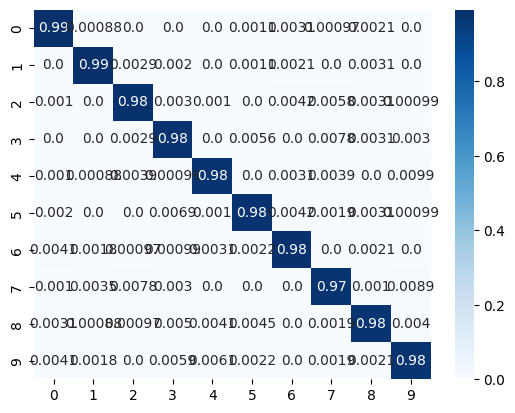

In [28]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, test_pred)

sb.heatmap(cfm / np.sum(cfm, axis=1), annot=True, fmt=".2", cmap="Blues")
plt.show()

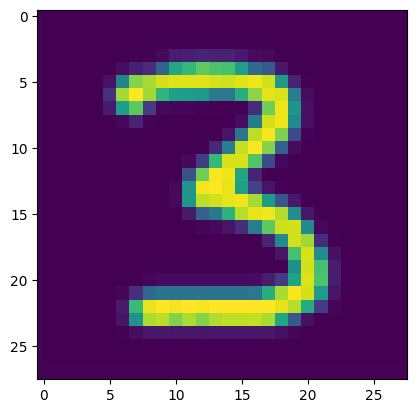

In [29]:
from PIL import Image

image = np.array(Image.open("/content/drive/My Drive/Google Colab/number.png").resize((28, 28)).convert("L"))

plt.imshow(image)
plt.show()

In [30]:
image = image.reshape(1, -1)
image = image / 255
image = scaler.transform(image)
image = tc.from_numpy(image).float()
image = image.cuda()

In [31]:
model.eval()

with tc.no_grad():
    prediction = tc.argmax(model(image), dim=1)

print("The model predicts the number", np.squeeze(prediction.cpu().numpy()), "in the image")

The model predicts the number 3 in the image


In [32]:
tc.save(model, "model.pth")

In [33]:
from google.colab import files

files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>